# 1. Prepare

## 1.1. Settings

In [31]:
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import concatenate, Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import threading
import time

%config InlineBackend.figure_format = 'retina'

In [35]:
input_size = 299
dropout = 0.8
batch_size = 16
batch_size_val = 16

epochs_phase_1 = 10
epochs_phase_2 = 20
epochs_phase_3 = 20

cpu_threads = 8

output_directory = './output/inceptionV3_with_dimensions'

## 1.2. Data and augmentaion

In [36]:
train_directory = './data/train'
validation_directory = './data/validation'
test_directory = './data/test'

In [37]:
def measure_seed(image):
    # convert to 0-255 BGR image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.convertScaleAbs(image, alpha=(255.0))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (15, 15), 0)
    _, threshold = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel)
    
    _, contours, _ = cv2.findContours(opening.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # choose contour with the largest area
    contours.sort(key=lambda c: cv2.contourArea(c))
    cnt = contours[-1]
    
    rect = cv2.minAreaRect(cnt)
    _, size, _  = rect

    w = int(sorted(size)[0])
    h = int(sorted(size)[1])
    
    return [w, h]

In [65]:
# for multi threading
# https://stackoverflow.com/a/41645042/1779687
class batchGenerator:
    def __init__(self, directory, generator, batch_size=16, shuffle=False):
        gen = generator.flow_from_directory(
            directory,
            target_size=(input_size, input_size),
            class_mode='categorical',
            batch_size=batch_size,
            shuffle=shuffle)
        self.generator = gen
        
        self.samples = gen.samples
        self.num_class = gen.num_class
        self.classes = gen.classes
        self.class_indices = gen.class_indices
        
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            X, y = self.generator.next()
            dimensions = [measure_seed(x) for x in X]
            return [np.array(X), np.array(dimensions)], y

# def data_generator(directory, generator, batch_size=32, shuffle=False):
#     images_generator = generator.flow_from_directory(
#         directory,
#         target_size=(input_size, input_size),
#         class_mode='categorical',
#         batch_size=batch_size,
#         shuffle=shuffle)

#     while True:
#         X, y = images_generator.next()
#         dimensions = [measure_seed(x) for x in X]
#         yield [np.array(X), np.array(dimensions)], y

In [66]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')

validgen = ImageDataGenerator(rescale=1./255)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = batchGenerator(
    train_directory,
    datagen,
    batch_size=batch_size,
    shuffle=True)

validation_generator = batchGenerator(
    validation_directory,
    validgen,
    batch_size=batch_size_val,
    shuffle=True)

test_generator = batchGenerator(
    test_directory,
    testgen,
    batch_size=1,
    shuffle=False)

train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

num_classes = train_generator.num_class

Found 24561 images belonging to 7 classes.
Found 11074 images belonging to 7 classes.
Found 1289 images belonging to 7 classes.


## 1.3. Model

In [50]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size, input_size, 3))

x = base_model.output
inception_out = GlobalAveragePooling2D()(x)

aux_input = Input(shape=(2,), name='aux_input')

x = concatenate([inception_out, aux_input])
x = Dense(2048, activation='relu')(x)
x = Dropout(dropout)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[base_model.input, aux_input], outputs=predictions)

# 2. Train

## 2.1. Phase 1
Train only the top layers (which were randomly initialized).

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_1.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_1.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.05,
    patience=2,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_1'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_1,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/10
1535/1535 [==============================] - 746s - loss: 0.9589 - acc: 0.7032 - val_loss: 0.6375 - val_acc: 0.7874
Epoch 3/10
1535/1535 [==============================] - 757s - loss: 0.9216 - acc: 0.7121 - val_loss: 0.5709 - val_acc: 0.8048
Epoch 4/10
 865/1535 [===============>..............] - ETA: 280s - loss: 0.9165 - acc: 0.7231

Load best epoch:

In [ ]:
model.load_weights('{}/checkpoints/phase_1.h5'.format(output_directory))

## 2.2. Phase 2
At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [ ]:
# train the top 2 inception blocks
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.adam(lr=1e-4),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_2.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_2.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=5,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_2'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, early_stopper, tensorboard],
    workers=cpu_threads)

1534/1535 [============================>.] - ETA: 0s - loss: 0.2299 - acc: 0.9303

Load best epoch:

In [ ]:
model.load_weights('{}/checkpoints/phase_2.h5'.format(output_directory))

## 2.3. Phase 3
Train all layers.

In [ ]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_3.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_3.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=5,
    verbose=1)

lr_reduce = ReduceLROnPlateau(verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_3'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_3,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, lr_reduce, early_stopper, tensorboard],
    workers=cpu_threads)

Load best epoch:

In [56]:
model.load_weights('{}/checkpoints/phase_3.h5'.format(output_directory))

# 3. Evaluate

## 3.1. Evaluate

In [57]:
score = model.evaluate_generator(test_generator, test_samples)

print('Test accuracy: {:.2f}'.format(score[1]))

Test accuracy: 0.98


## 3.2. Propagation time

In [68]:
t0 = time.time()
prediction = model.predict_generator(test_generator, test_samples)
pred_time = time.time() - t0

print('Propagation time of {} images: {:.3f} ms ({:.3f} ms per image)'.format(test_samples, pred_time * 1000.0, pred_time / test_samples * 1000.0))

Propagation time of 1289 images: 33208.928 ms (25.763 ms per image)


## 3.3. Confusion matrix

In [69]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

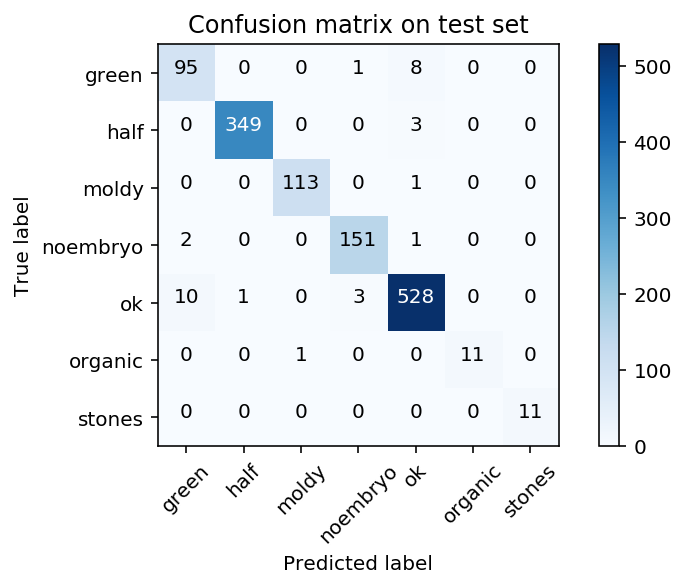

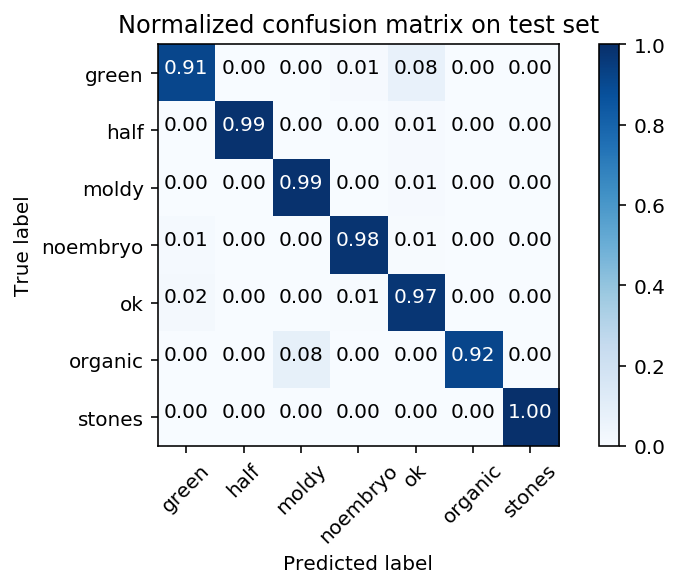

In [70]:
class_names = [key for (key, value) in sorted(test_generator.class_indices.items())]

test_pred = []
for i in prediction:
    test_pred.append(np.argmax(i))

test_cnf_matrix = confusion_matrix(test_generator.classes, test_pred)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names,
                      title='Confusion matrix on test set')
plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix on test set')
plt.show()